### This Notebook does both Feature Engineering I and II

In [228]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import pandas as pd
from comet_ml import Experiment
import os
from sklearn.model_selection import train_test_split

In [229]:
comet_workspace="vrbourque"

In [230]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [231]:
game_type_map = {"regular_season": "02",
                 "playoffs": "03"}


class Directory:
    DATA_DIR = "/Users/raphaelbourque/Desktop/data_science_class/Hockey_primer_2/data/" # Modify the path accordingly
    FIG_DIR = "/Users/raphaelbourque/Desktop/data_science_class/Hockey_primer_2/figures/" # Modify the path accordingly
    
class APIList():
    GET_ALL_MATCHES_FOR_A_GIVEN_SEASON = "https://statsapi.web.nhl.com/api/v1/schedule?season="
    GET_ALL_DATA_FOR_A_GIVEN_MATCH = "https://statsapi.web.nhl.com/api/v1/game/{}/feed/live/"


class CustomRegex():
    REGULAR_GAME_ID = r"\d{0,4}02\d{0,4}"  # 02 for regular season
    PLAYOFFS_ID = r"\d{0,4}03\d{0,4}"  # 03 for playoffs

TYPES_OF_SHOTS = ["Goal", "Shot"]

In [232]:
df = pd.read_pickle(Directory.DATA_DIR + 'all_season 1.pkl')
df = df.reset_index()


In [233]:
# Remove rows for which coordinates are null
df = df.loc[df['coordinates'].notnull()]
df = df.loc[df['last_event_coordinates'].notnull()]

In [234]:
# Remove rows that do not have full coordinates
def test(x):
    return(len(x)==2)
df = df[np.vectorize(test)(df['coordinates'])]
df = df[np.vectorize(test)(df['last_event_coordinates'])]

In [235]:
# Add distinct columns for x and y coordinates
df['x_coordinate'] = df['coordinates'].apply(lambda x: x[0])
df['y_coordinate'] = df['coordinates'].apply(lambda x: x[1])
df['last_event_x_coordinate'] = df['last_event_coordinates'].apply(lambda x: x[0])
df['last_event_y_coordinate'] = df['last_event_coordinates'].apply(lambda x: x[1])

In [236]:
# Replace NAs by np.nan and type as float
df['x_coordinate'].replace({'NA': np.nan}, inplace = True)
df['x_coordinate'] = df['x_coordinate'].astype('float')
df['y_coordinate'].replace({'NA': np.nan}, inplace = True)
df['y_coordinate'] = df['y_coordinate'].astype('float')

In [237]:
def distance(x_coordinate: float, y_coordinate: float, shoot_side: str) -> float:
    """
    This functions computes the distance at which a shot was taken, i.e. the distance between the coordinates and the goal, 
    taking the goal side into account
    @param x_coordinate: x coordinates on the ice
    @param y_coordinate: y coordinates on the ice
    @param shoot_side: side of the goal at which the shot is aimed at
    @return: distance
    """
    x = np.nan
    y = np.nan
    if shoot_side == 'right':
        x = 89 - x_coordinate
        y = y_coordinate
    elif shoot_side == 'left':
        x = -89 - x_coordinate
        y = y_coordinate
    else: 
        pass
    distance = math.hypot(x,y)
    return distance

In [238]:
def angle(x_coordinate: float, y_coordinate: float, shoot_side: str) -> float:
    """
    This functions computes the angle at which a shot was taken, i.e. the distance is 0 if the shot is taken from 
    in front of the goal, positive if from the right side, and negative if from the left side
    @param x_coordinate: x coordinates on the ice
    @param y_coordinate: y coordinates on the ice
    @param shoot_side: side of the goal at which the shot is aimed at
    @return: angle
    """
    x = np.nan
    y = np.nan
    if shoot_side == 'right':
        x = 89 - x_coordinate
        y = y_coordinate
    elif shoot_side == 'left':
        x = -(-89 - x_coordinate)
        y = y_coordinate
    else: 
        pass
    angle = math.atan2(y,x)*180/math.pi
    return angle

In [239]:
def distance_between_events(x_coordinate: float, y_coordinate: float, last_event_x_coordinate: float, last_event_y_coordinate: float) -> float:
    """
    This functions computes the distance between two points on the ice
    @param x_coordinate: x coordinates on the ice
    @param y_coordinate: y coordinates on the ice
    @return: distance
    """
    x = abs(x_coordinate - last_event_x_coordinate)
    y = abs(y_coordinate - last_event_y_coordinate)
    return math.hypot(x,y)

In [240]:
# Add the side of the goal at which the shot is aimed - this is the opposite side of that of the team which is shooting
df.loc[(df['action_team_name'] == df['away_team']), 'shoot_side'] = df.loc[(df['action_team_name'] == df['away_team']), 'home_team_side']
df.loc[(df['action_team_name'] == df['home_team']), 'shoot_side'] = df.loc[(df['action_team_name'] == df['home_team']), 'away_team_side']

# Compute the distance from the goal
df['distance'] = np.vectorize(distance)(df['x_coordinate'], df['y_coordinate'], df['shoot_side'])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in distance (vectorized)
  outputs = ufunc(*inputs)


In [241]:
# Compute the angle 
df['angle'] = np.vectorize(angle)(df['x_coordinate'], df['y_coordinate'], df['shoot_side'])

In [242]:
# Create Goal variable
df['is_goal'] = np.where(df['event']=='Goal',1,0)

In [243]:
# Create Empty Net variable
df['empty_net'] = np.where(df['event_empty_net']==True,1,0)

In [244]:
# Add season
df['season'] = df['game_id'].str[:4]

In [245]:
df['season'].unique()

array(['2015', '2016', '2017', '2018', '2019', '2020'], dtype=object)

In [246]:
# Period
df['game_period'] = df['about_period']

In [247]:
# Shot type
df['shot_type'] = df['event_secondary_type']

In [248]:
# Last event type
df['last_event_type'] = df['last_event_type_id']

In [249]:
# Distance from last event
df['distance_from_last_event'] = np.vectorize(distance_between_events)(df['x_coordinate'], df['y_coordinate'],df['last_event_x_coordinate'],df['last_event_y_coordinate'])

In [250]:
# Rebound
df['rebound'] = np.where(df['last_event_type']=='SHOT',True,False)

In [251]:
# Change in shot angle
df['last_shot_angle'] = df['angle'].shift(1) # Get the last shot angle
df['change_in_shot_angle'] = abs(df['angle'] - df['last_shot_angle']) # Absolute difference of angle
df.loc[df['rebound'] != True, 'change_in_shot_angle'] = 0 # Only include this value if the shot is a rebund, otherwise zero

In [252]:
# Speed: this is given in feet by second
df['game_seconds'] = df['game_time'].str[:2].astype(int)*60 + df['game_time'].str[3:].astype(int)
df['last_event_seconds'] = df['last_event_time'].str[:2].astype(int)*60 + df['last_event_time'].str[3:].astype(int)
df['speed'] = df['distance_from_last_event']/(df['game_seconds'] - df['last_event_seconds'])

In [253]:
# Keep only relevant columns
df = df[['game_id','distance','angle','is_goal','empty_net','season','game_period','shot_type','last_event_type','distance_from_last_event',
'rebound','change_in_shot_angle','speed','x_coordinate','y_coordinate','game_seconds']]
len(df)

458100

In [254]:
# Clean final dataset
df['speed'] = df['speed'].replace([np.inf],np.nan)
df = df.dropna(axis=0)
df = pd.get_dummies(df, columns=['shot_type','last_event_type'])

In [255]:
# Train test split
train_set = df[df['season'].isin(['2015', '2016', '2017', '2018'])]
evaluation_set = df[df['season'].isin(['2019'])]
x_train, x_val, y_train, y_val = train_test_split(train_set, train_set["is_goal"], test_size=0.2, stratify=train_set["is_goal"], random_state=42)

In [256]:
# Save Tidy Data for both Train and Final Test sets
train_set.to_pickle(Directory.DATA_DIR + 'train_set.pkl')
x_train.to_pickle(Directory.DATA_DIR + 'x_train.pkl')
x_val.to_pickle(Directory.DATA_DIR + 'x_val.pkl')
y_train.to_pickle(Directory.DATA_DIR + 'y_train.pkl')
y_val.to_pickle(Directory.DATA_DIR + 'y_val.pkl')
evaluation_set.to_pickle(Directory.DATA_DIR + 'final_evaluation_set.pkl')

In [257]:
train_set.shape

(315725, 31)

In [258]:
evaluation_set.shape

(71166, 31)

### Produce plots for Feature Engineering I

In [259]:
df = pd.read_pickle(Directory.DATA_DIR + 'train_set.pkl')

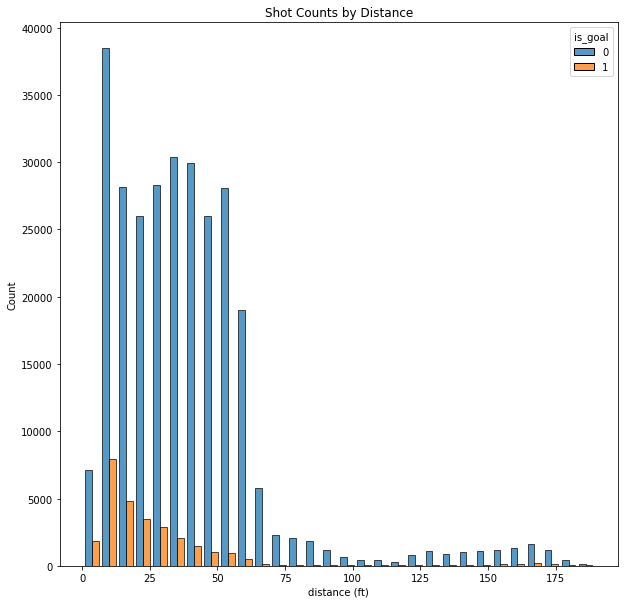

In [260]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.histplot(data=df, x='distance', bins=30, hue='is_goal', multiple="dodge", shrink=0.8)
ax.set(xlabel='distance (ft)')
ax.set(title='Shot Counts by Distance')
plt.show()
# Save figure
path = Directory.FIG_DIR + "figure_1_Shot_Counts_by_Distance.png"
fig.savefig(path)

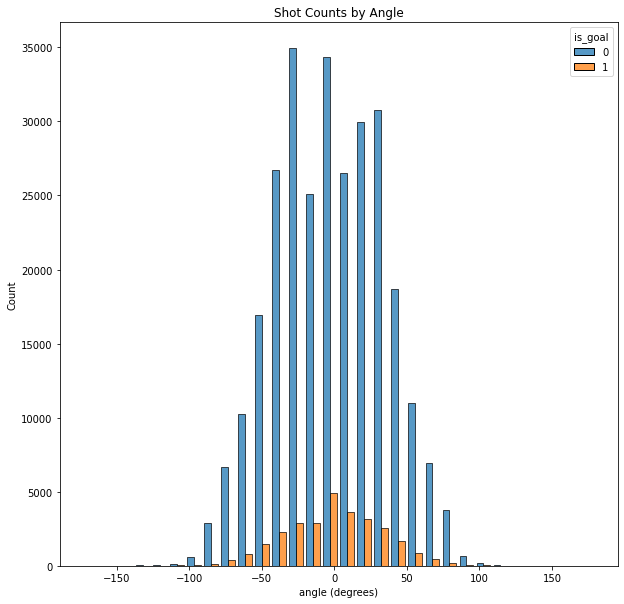

In [261]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.histplot(data=df, x='angle', bins=30, hue='is_goal', multiple="dodge", shrink=0.8)
ax.set(xlabel='angle (degrees)')
ax.set(title='Shot Counts by Angle')
plt.show()
# Save figure
path = Directory.FIG_DIR + "figure_2_Shot_Counts_by_Angle.png"
fig.savefig(path)

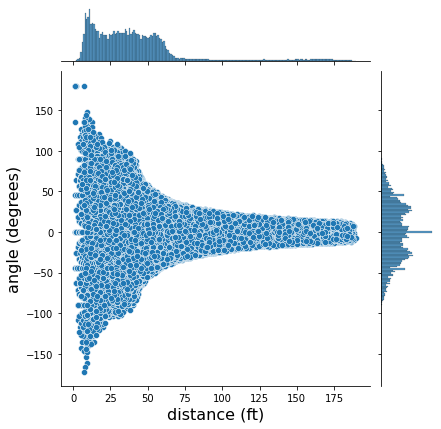

In [262]:
ax = sns.jointplot(data=df, x='distance', y='angle')
ax.set_axis_labels('distance (ft)', 'angle (degrees)', fontsize=16)
plt.show()
# Save figure
fig = ax.fig
path = Directory.FIG_DIR + "figure_3_jointplot_Distance_Angle.png"
fig.savefig(path)

In [263]:
df['distance_category'] = pd.cut(df['distance'], 30, ordered=True, precision=0)
goal_rate = df.groupby(by='distance_category').sum()/df.groupby(by='distance_category').count()
goal_rate['distance_category'] = goal_rate.index

/var/folders/9y/r6_mj9t93_jgmpqbq4lw0qd00000gn/T/ipykernel_23872/3119052018.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  goal_rate = df.groupby(by='distance_category').sum()/df.groupby(by='distance_category').count()


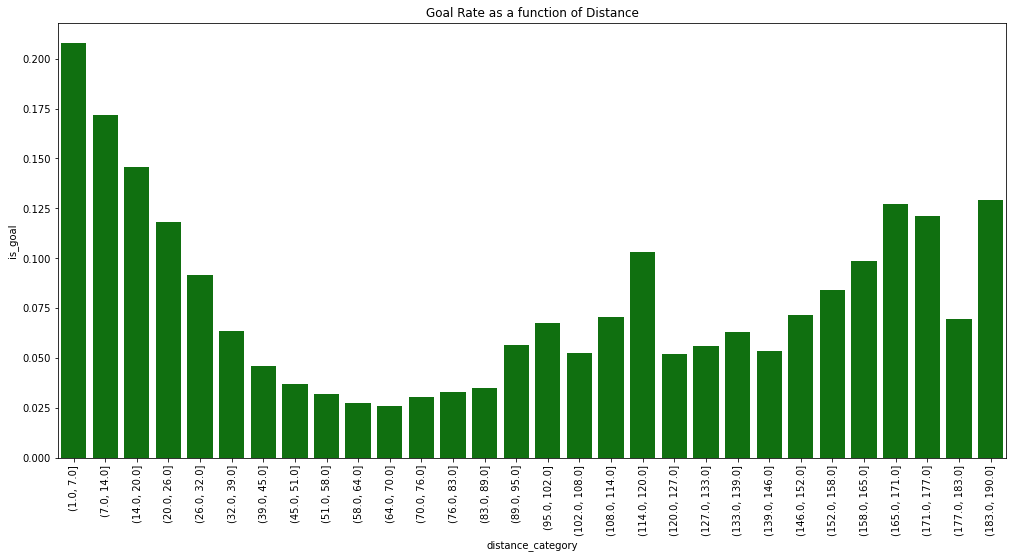

In [264]:
fig, ax = plt.subplots(figsize=(17, 8))
ax = sns.barplot(data=goal_rate, x='distance_category', y='is_goal', color='green')
ax.set(title='Goal Rate as a function of Distance')
plt.xticks(rotation=90)
plt.show()
# Save figure
path = Directory.FIG_DIR + "figure_4_Goal_Rate_as_a_function_of_Distance.png"
fig.savefig(path)

# Discuss observations:

First, there is a relationship between the distance and the probability of a goal, such as the probability of a goal is inversely proportionnal to distance when distance is less than approximately 60 ft. 

Second, there is some (stochastic) probability of a goal with shots taken at approximately more than 60 feet which can be in some cases higher than for goals taken at about 60 feet. 

In [265]:
df['angle_category'] = pd.cut(df['angle'], 30, ordered=True, precision=0)
goal_rate = df.groupby(by='angle_category').sum()/df.groupby(by='angle_category').count()
goal_rate['angle_category'] = goal_rate.index

/var/folders/9y/r6_mj9t93_jgmpqbq4lw0qd00000gn/T/ipykernel_23872/2710182898.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  goal_rate = df.groupby(by='angle_category').sum()/df.groupby(by='angle_category').count()


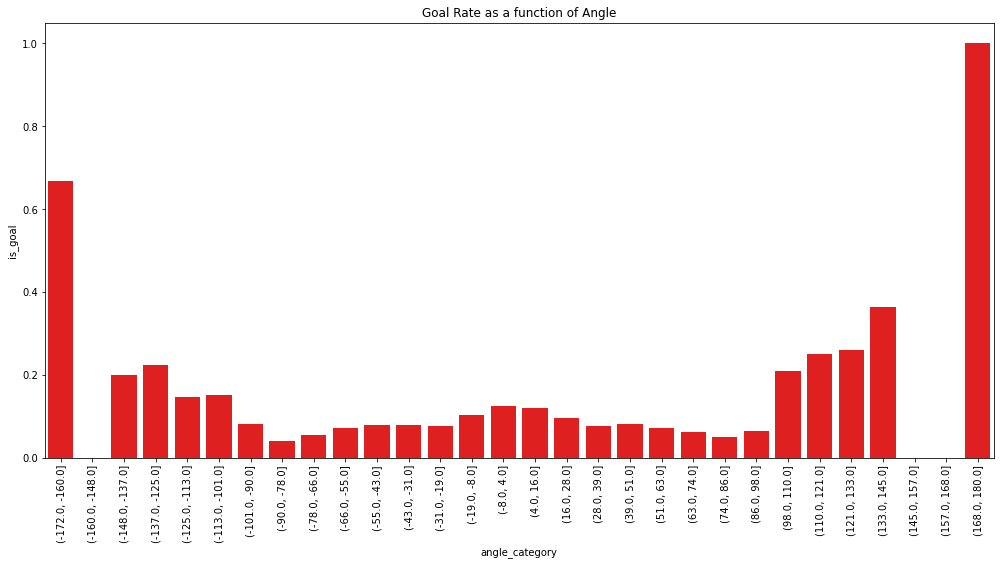

In [266]:
fig, ax = plt.subplots(figsize=(17, 8))
ax = sns.barplot(data=goal_rate, x='angle_category', y='is_goal', color='red')
ax.set(title='Goal Rate as a function of Angle')
plt.xticks(rotation=90)
plt.show()
# Save figure
path = Directory.FIG_DIR + "figure_5_Goal_Rate_as_a_function_of_Angle.png"
fig.savefig(path)

# Discuss observations
First, there is slighly more chance that a goal results in a goal when it is taken from in front of the goal, but only when the shot is taken at less than 90 degrees. 

Second, even though shots taken from in front of the goal (i.e. at an angle close to zero) are the most common, these are not the most successful in achieving a goal. In fact, the likelihood of a goal increases as a proportion to the angle, specifically when the angle is greater than approximately 90 degrees. 

Third and very important, the distribution is symmetric only in its middle part. There is a very clear asymetry when comparing the extremities of the distribution. Specifically, shots taken at very high angles (approximately more than 150 degrees) are more likely to achieve a goal when taken from the side which corresponds to the right-hand side of the goaley. We need to bear in mind that most goaleys are right-handed and hold their hockey sticks on the left side as all other players, and therefore their right side is relatively unprotected. This might explain why shots taken from the far-right-hand side of the goaley are much more likely to result in a goal. 

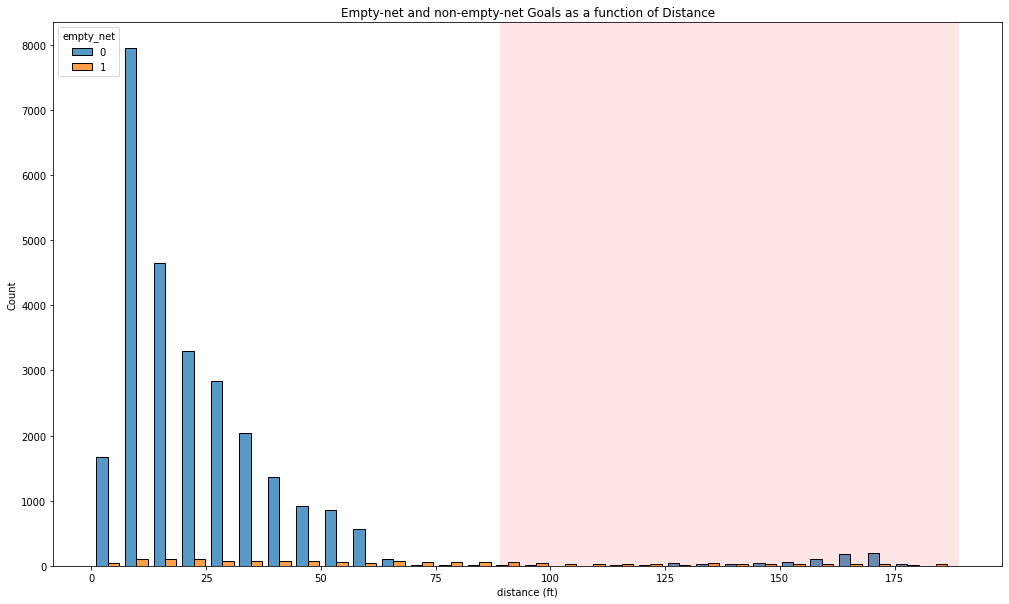

In [267]:
fig, ax = plt.subplots(figsize=(17, 10))
ax = sns.histplot(data=df[(df["is_goal"]==1)], bins=30, x='distance', hue='empty_net',multiple="dodge", shrink=0.8)
ax.set(title='Empty-net and non-empty-net Goals as a function of Distance')
ax.set(xlabel='distance (ft)')
plt.axvspan(89, 189, color='red', alpha=0.1, lw=0)
plt.show()
# Save figure
path = Directory.FIG_DIR + "figure_6_Empty_net_or_not_as_a_function_of_Distance.png"
fig.savefig(path)

In [268]:
len(df[(df['is_goal']==1) & (df['distance']>89) & (df['empty_net']==0)])

745

Note: Here, we indicate the approximate defense zone by a red shade, from 89 feet from the goal up to 180 feet. This is an approximation because distance are measured from the goal and thus are not always calculated perpendicular to the central line. 

# Answer: 
The distribution is coherent with domain-specific knowledge (i.e. that “it is incredibly rare to score a non-empty net goal on the opposing team from within your defensive zone”). Indeed, few successful goals (in total, 795 goals for the complete seasons involved) were shot from more than 89 feet. Based on this, it seems that the features are correct, and we cannot find any events that have incorrect features. 

### Feature Engineering II

In [269]:
# Filter your dataset to the game ID “2017021065”.
subset_df = df[df['game_id'] == '2017021065']

In [270]:
# Save to Comet
experiment = Experiment( 
    api_key=os.environ.get('COMET_API_KEY'), 
    project_name='feature_engineering_data',
    workspace=comet_workspace,
    ) 
experiment.log_dataframe_profile(
    subset_df,
    name='wpg_v_wsh_2017021065', # keep this name 
    dataframe_format='csv' # ensure you set this flag!
)

ValueError: Comet.ml requires an API key. Please provide as the first argument to Experiment(api_key) or as an environment variable named COMET_API_KEY 